# UCB Intro to Deep Learning, Week 3 Assignment - Kaggle competition on Histopathologic Cancer Detection

## GitHub link https://github.com/erikhel/UCB-DL-Class-Week-3

In [1]:
import keras
from keras import layers
import tensorflow as tf

import math 
import numpy as np
import pandas as pd
import random

import os
import pathlib

import cv2
import PIL
import PIL.Image

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(font_scale=1.5)
sns.set_style('white')
#plt.rcParams['figure.figsize']=(10,5)

# Step 1:  Brief description of the problem and data

Conclusions from the description on Kaggle and first look at data:
* Binary classification problem, detect cancer (positive class, label 1) or not (negative class, label 0)
* Images are raw TIF 96x96 pixels in RGB, the area of interest is the center 32x32 pixels
* 220,025 images for training, 57,458 for testing. Overall class balance is 59% negative, 41% positive.

## Load and inspect data

In [3]:
train_dir = pathlib.Path('train/')
test_dir = pathlib.Path('test/')

In [4]:
df_labels = pd.read_csv('train_labels.csv')
df_labels.info()
df_labels = df_labels.set_index('id')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [5]:
# label stats
df_labels['label'].value_counts() / df_labels.shape[0] * 100

0    59.496875
1    40.503125
Name: label, dtype: float64

In [6]:
train_fnames = list(train_dir.glob('**/*.tif'))
test_fnames  = list(test_dir.glob('**/*.tif'))
print('No of images: {} for training, {} for testing'.format(len(train_fnames),len(test_fnames)))

No of images: 220025 for training, 57458 for testing


In [7]:
img = PIL.Image.open(train_fnames[0])
print(f'Image is a {img.format} in {img.mode} and {img.height} x {img.width}')

Image is a TIFF in RGB and 96 x 96


# Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

Comments:

* It's far from obvious to an untrained eye what is positive versus negative class.
* There are a number of "flat" images with low information content, here defined as low range of pixel values. With a threshold of 10, there are 21 outliers in the training set (prevalence 0.01%) and all have a negative label. One might be tempted to remove these, however they are kept here because there might be similar images in the test set and we want the model to be trained to correctly predict such flat images.
* The output of the step is data prepared for modeling by loading images and splitting training and validation data (80:20).

## Plot samples of training data

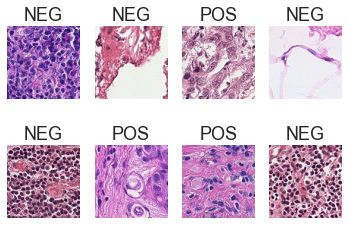

In [8]:
f,ax = plt.subplots(nrows=2, ncols=4)
ax = ax.flatten()
for k in range(0,8):
    i = random.randrange(0,len(train_fnames))
    img = PIL.Image.open(train_fnames[i])
    ax[k].imshow(img)
    
    id = train_fnames[i].name.split('.')[0]
    lbl = df_labels.loc[id,'label']
    if lbl==False:
        s = 'NEG'
    else:
        s = 'POS'
    ax[k].set_title(s)
    ax[k].axis('off')

## Plot samples of test data

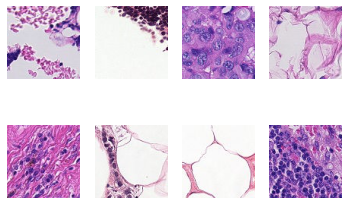

In [9]:
f,ax = plt.subplots(nrows=2, ncols=4)
ax = ax.flatten()
for k in range(0,8):
    i = random.randrange(0,len(test_fnames))
    img = PIL.Image.open(test_fnames[i])
    ax[k].imshow(img)
    ax[k].axis('off')

## Check for outliers

Outliers here defined as images with low range between pixel values and assumed to have low to no information

In [10]:
df_alltrain = df_labels.copy()
df_alltrain['range'] = 255

In [11]:
for idx,ds in df_alltrain.iterrows():
    fname = os.path.join(train_dir, idx) + '.tif'
    img = cv2.imread(fname)
    df_alltrain.loc[idx,'range'] = img.max() - img.min()

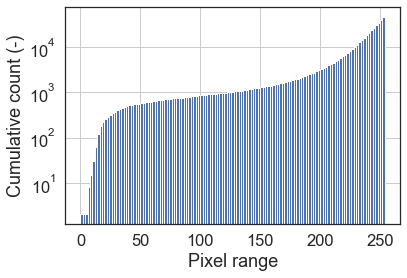

Text(0, 0.5, 'Count (-)')

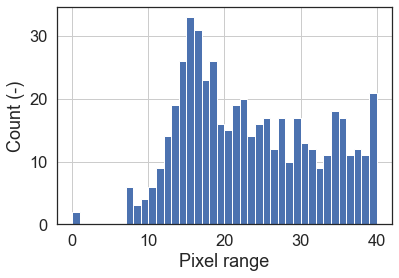

In [12]:
df_alltrain.range.hist(bins=range(0,255,2), cumulative=True)
plt.yscale('log')
plt.xlabel('Pixel range'); plt.ylabel('Cumulative count (-)')
plt.show()
df_alltrain.range.hist(bins=range(0,41,1), cumulative=False)
plt.xlabel('Pixel range'); plt.ylabel('Count (-)')

21 out of 220025, 0.010%


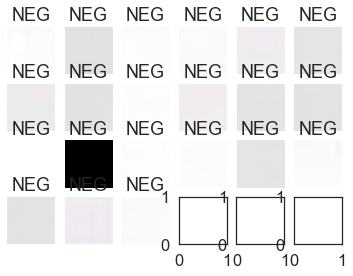

In [13]:
df_low = df_alltrain[df_alltrain.range<=10]
low_range_ids = df_low.index.values
N = df_low.shape[0]
print(f'{N} out of {df_alltrain.shape[0]}, {N/df_alltrain.shape[0]:.3%}')
ncols = 6
nrows = math.ceil(N/ncols)

f,ax = plt.subplots(nrows=nrows, ncols=ncols)
ax = ax.flatten(); k = 0
for idx,ds in df_low.iterrows():
    fname = os.path.join(train_dir, idx) + '.tif'
    lbl = df_labels.loc[id,'label']
    if lbl==False:
        s = 'NEG'
    else:
        s = 'POS'
    
    ax[k].imshow(PIL.Image.open(fname))
    ax[k].axis('off')
    ax[k].set_title(s)    
    k += 1

In [14]:
#df_clean_train = df_alltrain[~df_alltrain.index.isin(low_range_ids)]
#print('After cleaning, {} training samples remaining out of {}'.format(df_clean_train.shape[0], df_alltrain.shape[0]))

In [15]:
#clean_train_ids = df_clean_train.index.values
#clean_train_fnames = [os.path.join(train_dir,id + '.tif') for id in clean_train_ids]
clean_train_ids = df_labels.index.values
clean_train_fnames = train_fnames

## Prepare data for modeling

### Crop and export images

* The interesting area is the 32x32 box in the center of the images. The images are therefore cropped to that size (zero-padding used later) in order to focus on the relevant area.
* After cropping, export images to BMP to enable subsequent use of the convenient tf.keras.utils.image_dataset_from_directory() function (which does not support TIFF).

In [16]:
CROP_SIZE = 32 # square size for cropping

def crop_image(img, crop_sz):
    # Original size, assuming square
    org_sz = img.shape[0]
    # New bounding box
    z0 = (org_sz - crop_sz) // 2
    z1 = z0 + crop_sz
    # Crop to box = (z0, z0, z1, z1)
    return img[z0:z1, z0:z1]

def crop_export_image(path,outdir):
    # Get paths and filenames
    parts = os.path.split(path);
    d = parts[:-1]
    id = parts[-1][:-4]
    f = id + '.bmp'
    # Get label
    if id in df_labels.index:
        if df_labels.loc[id,'label'] == 0:
            outdir = os.path.join(outdir,'0')
        else:
            outdir = os.path.join(outdir,'1')
    else:
        outdir = os.path.join(outdir,'test')
    # Load and crop
    bgr_img = cv2.imread(path)
    bgr_img = crop_image(bgr_img, CROP_SIZE)
    # Save new file
    outpath = os.path.join(outdir,f)
    cv2.imwrite(outpath, bgr_img)

    return outpath

In [17]:
for p in clean_train_fnames:
    crop_export_image(str(p), 'train/bmp')
for p in test_fnames:
    crop_export_image(str(p), 'test/bmp')

### Create TF datasets

* Prepare for training by creating TF datasets.
* Plot a few images as a spot-check that we are OK.

In [18]:
BATCH_SIZE = 32
RANDOM_SEED = 17
bmp_train_dir = 'train/bmp'

train_ds = tf.keras.utils.image_dataset_from_directory(
  bmp_train_dir,
  validation_split = 0.2,
  subset = 'training',
  seed = RANDOM_SEED,
  image_size = (CROP_SIZE, CROP_SIZE),
  batch_size = BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  bmp_train_dir,
  validation_split = 0.2,
  subset = 'validation',
  seed = RANDOM_SEED,
  image_size = (CROP_SIZE, CROP_SIZE),
  batch_size = BATCH_SIZE)

Found 220025 files belonging to 2 classes.
Using 176020 files for training.


2022-09-24 17:26:45.618579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 220025 files belonging to 2 classes.
Using 44005 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['0', '1']


In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

2022-09-24 17:27:07.814334: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


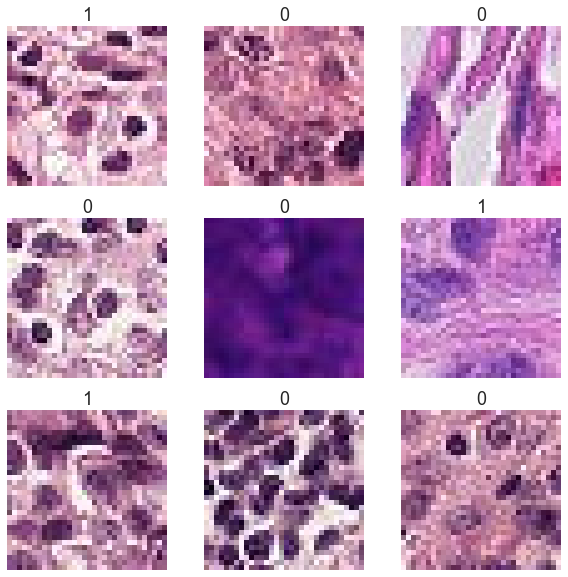

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Step 3: Model Architecture

A type of architechture that has shown to perform well (e.g., used in VGGNet) is repeated elements of 2 convolutional layers and 1 pooling layer (CNN-pool elements) followed by dense layers (dense elements). Important design parameters become the number of these elements and their respective design parameters.

With the limited time available, the approach taken here is fairly small networks where the number of CNN-pool and dense elements are varied between 1 and 2. The table below summarizes the alternatives.

| Model#  | Nickname | #CNN-pool | #Dense | #Param |
| --|------|---|---|---------|
| 1 | 1c1d | 1 | 1 | 66,425 |
| 2 | 2c1d | 2 | 1 | 37,177 |
| 3 | 1c2d | 1 | 2 | 67,481 |
| 4 | 2c2d | 2 | 2 | 38,233 |

The filter size is 3x3, filter numbers are 8 and 16, number of units is 32, and activation function is ReLu for hidden layers and sigmoid for output layer.
 
Regularization is added in form of batch normalization (of the feature maps) prior to pooling in CNN-pool elements and dropout prior to dense layers with rate 0.25. All models start with a rescaling layer to normalize inputs between 0 and 1, as this range of values is recommended for network training.

## Model 1 (1c1d): 1 CNN-pool element + 1 dense layer

In [22]:
inputs = keras.Input(shape=(CROP_SIZE,CROP_SIZE,3))
x = layers.Rescaling(scale=1.0/255.0)(inputs)

x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = layers.Flatten()(x)

x = layers.Dropout(rate=0.25)(x)
x = layers.Dense(units=32, activation='relu')(x)

outputs = layers.Dense(units=1, activation='sigmoid')(x)

model1 = keras.Model(inputs = inputs, outputs = outputs)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 8)        32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                           

## Model 2 (2c1d): 2 CNN-pool elements + 1 dense layer

In [23]:
inputs = keras.Input(shape=(CROP_SIZE,CROP_SIZE,3))
x = layers.Rescaling(scale=1.0/255.0)(inputs)

x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = layers.Flatten()(x)

x = layers.Dropout(rate=0.25)(x)
x = layers.Dense(units=32, activation='relu')(x)

outputs = layers.Dense(units=1, activation='sigmoid')(x)

model2 = keras.Model(inputs = inputs, outputs = outputs)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 8)        32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                       

## Model 3 (1c2d): 1 CNN-pool element + 2 dense layers

In [24]:
inputs = keras.Input(shape=(CROP_SIZE,CROP_SIZE,3))
x = layers.Rescaling(scale=1.0/255.0)(inputs)

x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = layers.Flatten()(x)

x = layers.Dropout(rate=0.25)(x)
x = layers.Dense(units=32, activation='relu')(x)

x = layers.Dropout(rate=0.25)(x)
x = layers.Dense(units=32, activation='relu')(x)

outputs = layers.Dense(units=1, activation='sigmoid')(x)

model3 = keras.Model(inputs = inputs, outputs = outputs)
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 8)        32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                       

## Model 4 (2c2d): 2 CNN-pool elements + 2 dense layers

In [25]:
inputs = keras.Input(shape=(CROP_SIZE,CROP_SIZE,3))
x = layers.Rescaling(scale=1.0/255.0)(inputs)

x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_last')(x)
x = layers.BatchNormalization(axis=3)(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = layers.Flatten()(x)

x = layers.Dropout(rate=0.25)(x)
x = layers.Dense(units=32, activation='relu')(x)

x = layers.Dropout(rate=0.25)(x)
x = layers.Dense(units=32, activation='relu')(x)

outputs = layers.Dense(units=1, activation='sigmoid')(x)

model4 = keras.Model(inputs = inputs, outputs = outputs)
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 8)        32        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                       

# Step 4: Results and Analysis

The different architectures are trained and the results are compared. The learning rate parameter was first set at 1e-3. A faster (1e-2) did not give better result (in terms of validation accuracy), but a slower (1e-4) did. The convergence was quite slow and to save time and epochs, the learning rate was finally set to 2e-4 giving good results in reasonasble time relative to the other parameter settings.

From the results, presented in below figures, the following observations are made.
* The rate of decay of the loss is fairly slow and only 10 epochs are used. Model 1 and 2 start to show some tendencies of overfitting. For this small test, there is not a clear correlation between the number of parameters and the gap between the train and validation metrics.
* The final validation AUC is similar and around 90% for all models.
* The figure of validation AUC versus number of parameters indicate that model 4 with 38k parameters obtains the best validation AUC while model 3 with 67k parameters has slightly lower AUC but a smaller gap between test and validation metrics. In summary, the performance of the models are similar.

In [27]:
LEARNING_RATE = 2e-4
EPOCHS = 10

In [32]:
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.AUC(name='auc')])
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.AUC(name='auc')])
model3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.AUC(name='auc')])
model4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.AUC(name='auc')])

In [33]:
model1_out = model1.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/10
5501/5501 [==============================] - 108s 19ms/step - loss: 0.4532 - auc: 0.8597 - val_loss: 0.4457 - val_auc: 0.8655
Epoch 2/10
5501/5501 [==============================] - 103s 19ms/step - loss: 0.4442 - auc: 0.8658 - val_loss: 0.4519 - val_auc: 0.8654
Epoch 3/10
5501/5501 [==============================] - 100s 18ms/step - loss: 0.4379 - auc: 0.8702 - val_loss: 0.4338 - val_auc: 0.8737
Epoch 4/10
5501/5501 [==============================] - 97s 18ms/step - loss: 0.4325 - auc: 0.8739 - val_loss: 0.4295 - val_auc: 0.8759
Epoch 5/10
5501/5501 [==============================] - 97s 18ms/step - loss: 0.4274 - auc: 0.8773 - val_loss: 0.4309 - val_auc: 0.8758
Epoch 6/10
5501/5501 [==============================] - 98s 18ms/step - loss: 0.4234 - auc: 0.8799 - val_loss: 0.4284 - val_auc: 0.8775
Epoch 7/10
5501/5501 [==============================] - 96s 17ms/step - loss: 0.4185 - auc: 0.8831 - val_loss: 0.4277 - val_auc: 0.8785
Epoch 8/10
5501/5501 [=======================

In [34]:
model2_out = model2.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/10
5501/5501 [==============================] - 140s 25ms/step - loss: 0.4883 - auc: 0.8349 - val_loss: 0.4529 - val_auc: 0.8649
Epoch 2/10
5501/5501 [==============================] - 139s 25ms/step - loss: 0.4478 - auc: 0.8629 - val_loss: 0.4553 - val_auc: 0.8694
Epoch 3/10
5501/5501 [==============================] - 138s 25ms/step - loss: 0.4336 - auc: 0.8727 - val_loss: 0.4328 - val_auc: 0.8792
Epoch 4/10
5501/5501 [==============================] - 149s 27ms/step - loss: 0.4230 - auc: 0.8794 - val_loss: 0.4264 - val_auc: 0.8830
Epoch 5/10
5501/5501 [==============================] - 142s 26ms/step - loss: 0.4157 - auc: 0.8839 - val_loss: 0.4177 - val_auc: 0.8838
Epoch 6/10
5501/5501 [==============================] - 141s 26ms/step - loss: 0.4104 - auc: 0.8872 - val_loss: 0.4186 - val_auc: 0.8846
Epoch 7/10
5501/5501 [==============================] - 142s 26ms/step - loss: 0.4049 - auc: 0.8904 - val_loss: 0.4420 - val_auc: 0.8834
Epoch 8/10
5501/5501 [===================

In [35]:
model3_out = model3.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/10
5501/5501 [==============================] - 95s 17ms/step - loss: 0.5030 - auc: 0.8259 - val_loss: 0.4553 - val_auc: 0.8611
Epoch 2/10
5501/5501 [==============================] - 94s 17ms/step - loss: 0.4627 - auc: 0.8546 - val_loss: 0.4464 - val_auc: 0.8668
Epoch 3/10
5501/5501 [==============================] - 94s 17ms/step - loss: 0.4536 - auc: 0.8605 - val_loss: 0.4451 - val_auc: 0.8715
Epoch 4/10
5501/5501 [==============================] - 94s 17ms/step - loss: 0.4466 - auc: 0.8651 - val_loss: 0.4550 - val_auc: 0.8715
Epoch 5/10
5501/5501 [==============================] - 94s 17ms/step - loss: 0.4385 - auc: 0.8703 - val_loss: 0.4285 - val_auc: 0.8808
Epoch 6/10
5501/5501 [==============================] - 95s 17ms/step - loss: 0.4318 - auc: 0.8746 - val_loss: 0.4188 - val_auc: 0.8851
Epoch 7/10
5501/5501 [==============================] - 94s 17ms/step - loss: 0.4263 - auc: 0.8782 - val_loss: 0.4279 - val_auc: 0.8779
Epoch 8/10
5501/5501 [==========================

In [36]:
model4_out = model4.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/10
5501/5501 [==============================] - 139s 25ms/step - loss: 0.4979 - auc: 0.8281 - val_loss: 0.4517 - val_auc: 0.8642
Epoch 2/10
5501/5501 [==============================] - 139s 25ms/step - loss: 0.4546 - auc: 0.8589 - val_loss: 0.4375 - val_auc: 0.8744
Epoch 3/10
5501/5501 [==============================] - 142s 26ms/step - loss: 0.4382 - auc: 0.8702 - val_loss: 0.4276 - val_auc: 0.8827
Epoch 4/10
5501/5501 [==============================] - 139s 25ms/step - loss: 0.4279 - auc: 0.8769 - val_loss: 0.4212 - val_auc: 0.8867
Epoch 5/10
5501/5501 [==============================] - 143s 26ms/step - loss: 0.4196 - auc: 0.8821 - val_loss: 0.4192 - val_auc: 0.8892
Epoch 6/10
5501/5501 [==============================] - 143s 26ms/step - loss: 0.4118 - auc: 0.8868 - val_loss: 0.4032 - val_auc: 0.8948
Epoch 7/10
5501/5501 [==============================] - 147s 27ms/step - loss: 0.4051 - auc: 0.8906 - val_loss: 0.3993 - val_auc: 0.8952
Epoch 8/10
5501/5501 [===================

## Plots

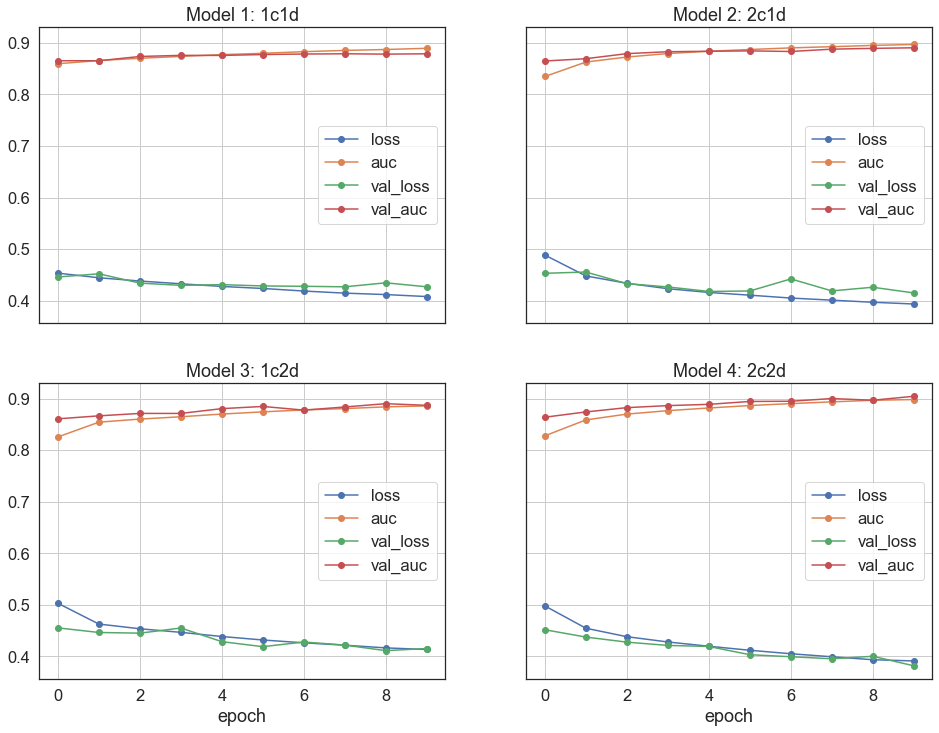

In [38]:
f,ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16,12))
ax = ax.flatten()
for k in model1_out.history.keys():
    ax[0].plot(model1_out.history[k],'o-', label=k)
ax[0].set_title(f'Model 1: 1c1d'); 
for k in model2_out.history.keys():
    ax[1].plot(model2_out.history[k],'o-', label=k)
ax[1].set_title(f'Model 2: 2c1d');
for k in model3_out.history.keys():
    ax[2].plot(model3_out.history[k],'o-', label=k)
ax[2].set_title(f'Model 3: 1c2d');
for k in model4_out.history.keys():
    ax[3].plot(model4_out.history[k],'o-', label=k)
ax[3].set_title(f'Model 4: 2c2d');

ax[2].set_xlabel('epoch')
ax[3].set_xlabel('epoch')
for a in ax:
    a.legend()
    a.grid()

,no_param,train_auc_pct,val_auc_pct
0,66425,0.889605,0.878957
1,37177,0.897025,0.890580
2,67481,0.886128,0.887189
3,38233,0.898465,0.904820


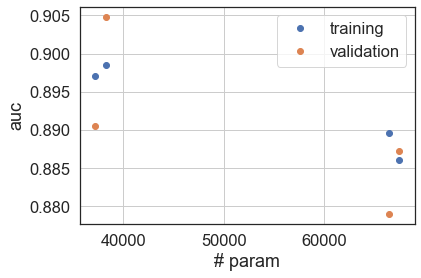

In [70]:
no_param = [keras.utils.layer_utils.count_params(x.trainable_weights) for x in [model1,model2,model3,model4]]
train_auc = [x.history['auc'][-1] for x in [model1_out,model2_out,model3_out,model4_out]]
val_auc = [x.history['val_auc'][-1] for x in [model1_out,model2_out,model3_out,model4_out]]
plt.plot(no_param, train_auc , 'o', label='training')
plt.plot(no_param, val_auc , 'o', label='validation')
plt.xlabel('# param'); plt.ylabel('auc')
plt.legend(); plt.grid();
pd.DataFrame({'no_param': no_param, 'train_auc_pct': train_auc,'val_auc_pct': val_auc})

# Step 5: Conclusion

The results are summarized in the figures above and the table below.

| Model#  | Nickname | #CNN-pool | #Dense | #Param | Validation AUC % |
| --|------|---|---|---------|--|
| 1 | 1c1d | 1 | 1 | 66,425 | 88
| 2 | 2c1d | 2 | 1 | 37,177 | 89
| 3 | 1c2d | 1 | 2 | 67,481 | 89
| 4 | 2c2d | 2 | 2 | 38,233 | 90

Model 4 with validation AUC 90% was submitted to Kaggle and achieved AUC of 83% (private) and 89 (public). The gap to the "public" part is small while the larger gap to the "private" part indicates some overfit to the training data.

The resulting validation AUC of 90% may be improved with more alternatives (architectures) and longer training times (epochs). Specifically, deeper networks with additional CNN-pool elements with fine-tuned filter parameters together with more epochs is one direction. Transfer learning may also be explored using one of the existing state-of-the-art CNN networks.

## Make predictions on test data

In [60]:
bmp_test_dir = 'test/bmp/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    bmp_test_dir,
    labels = None,
    shuffle = False,
    image_size = (CROP_SIZE, CROP_SIZE),
    batch_size = BATCH_SIZE)

Found 57458 files belonging to 1 classes.


In [61]:
pred = model4.predict(test_ds)

1796/1796 [==============================] - 11s 6ms/step


In [62]:
ids = [os.path.split(x)[1].split('.')[0] for x in test_ds.file_paths]

In [63]:
df_sub = pd.DataFrame({'id': ids, 'label': pred.flatten()}).set_index('id')
df_sub['class'] = np.where(df_sub.label > 0.5, 1, 0)
df_sub['label'].to_csv('submission.csv', index=True)

In [64]:
df_sub.describe()

,label,class
count,5.745800e+04,57458.000000
mean,3.779531e-01,0.318372
std,3.077362e-01,0.465849
min,1.356992e-07,0.000000
25%,1.131772e-01,0.000000
50%,2.784429e-01,0.000000
75%,6.404011e-01,1.000000
max,9.990382e-01,1.000000
